<a href="https://colab.research.google.com/github/fajrunwm/gisml/blob/main/Agriculture_Augmentation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agriculture Augmentation

# Phase 1: Satellite Data Transformation

## Data Preparation

In [1]:
# Install required libraries
#!pip install pystac_client planetary_computer rasterio

In [2]:
# Environment setup
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer as pc
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

In [3]:
# Data access
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace,
)

print("Connected to MPC Catalog")

Connected to MPC Catalog


In [4]:
# Search for Dataset Collection
#for collection in sorted(catalog.get_all_collections(), key=lambda c: c.id):
  #print(collection.id)

In [5]:
# Define Area of Interest (AOI)
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [101.004689, 0.854101],  # Top left
            [101.172633, 0.854101],  # Top right
            [101.172633, 0.724275],  # Bottom right
            [101.004689, 0.724275],  # Bottom left
            [101.004689, 0.854101],  # Closing the polygon
        ]
    ],
}

In [6]:
# Define Time of Interest (TOI)
toi = "2023-01-01/2024-12-31"

# Define Could Cover tolerance
cc = 25

In [7]:
# Search for Sentinel-2 data with cloud cover filter
search = catalog.search(
    collections=["sentinel-2-l2a"],  # Dataset
    intersects=aoi,    # Area of Interest
    datetime=toi,  # Date range
    query={"eo:cloud_cover": {"lt": cc}},  # Cloud cover filter (<10%)
)

# Check how many items were found
items = list(search.items())
print(f"Found {len(items)} items with cloud cover < {cc}%:")
for i in items:
    print(f"<> {i.datetime.date()} with cloud cover {eo.ext(i).cloud_cover}%.")

Found 7 items with cloud cover < 25%:
<> 2024-09-24 with cloud cover 19.776554%.
<> 2024-07-11 with cloud cover 24.700031%.
<> 2024-07-11 with cloud cover 12.136421%.
<> 2023-08-06 with cloud cover 21.42489%.
<> 2023-06-17 with cloud cover 12.931514%.
<> 2023-04-13 with cloud cover 24.83363%.
<> 2023-04-13 with cloud cover 2.956269%.


In [8]:
# Choose the least cloudy item
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover."
)

Choosing S2A_MSIL2A_20230413T032511_R018_T47NQA_20230413T101752 from 2023-04-13 with 2.956269% cloud cover.


In [9]:
# Get the first item
#item = next(search.get_items())

# Sign the item's assets for direct access
signed_item = pc.sign(least_cloudy_item)

# Collect band information
band_info = []

for asset_key, asset in signed_item.assets.items():
    bands = asset.extra_fields.get('eo:bands', [])
    for band in bands:
        band_info.append({
            "Asset Title": asset.title,
            #"Asset": asset_key,
            "Band Name": band.get("name", "N/A"),
            "Common Name": band.get("common_name", "N/A"),
            "Resolution (m)": asset.extra_fields.get("gsd", "N/A"),  # Extract spatial resolution
            "Center Wavelength (µm)": band.get("center_wavelength", "N/A"),
            "Full Width Half Max (µm)": band.get("full_width_half_max", "N/A"),
        })

# Convert to a DataFrame
band_df = pd.DataFrame(band_info)

# Display the DataFrame
band_df

,Asset Title,Band Name,Common Name,Resolution (m),Center Wavelength (µm),Full Width Half Max (µm)
0,Band 1 - Coastal aerosol - 60m,B01,coastal,60.0,0.443,0.027
1,Band 2 - Blue - 10m,B02,blue,10.0,0.490,0.098
2,Band 3 - Green - 10m,B03,green,10.0,0.560,0.045
3,Band 4 - Red - 10m,B04,red,10.0,0.665,0.038
4,Band 5 - Vegetation red edge 1 - 20m,B05,rededge,20.0,0.704,0.019
5,Band 6 - Vegetation red edge 2 - 20m,B06,rededge,20.0,0.740,0.018
6,Band 7 - Vegetation red edge 3 - 20m,B07,rededge,20.0,0.783,0.028
7,Band 8 - NIR - 10m,B08,nir,10.0,0.842,0.145
8,Band 9 - Water vapor - 60m,B09,N/A,60.0,0.945,0.026
9,Band 11 - SWIR (1.6) - 20m,B11,swir16,20.0,1.610,0.143


## Image Visualisation

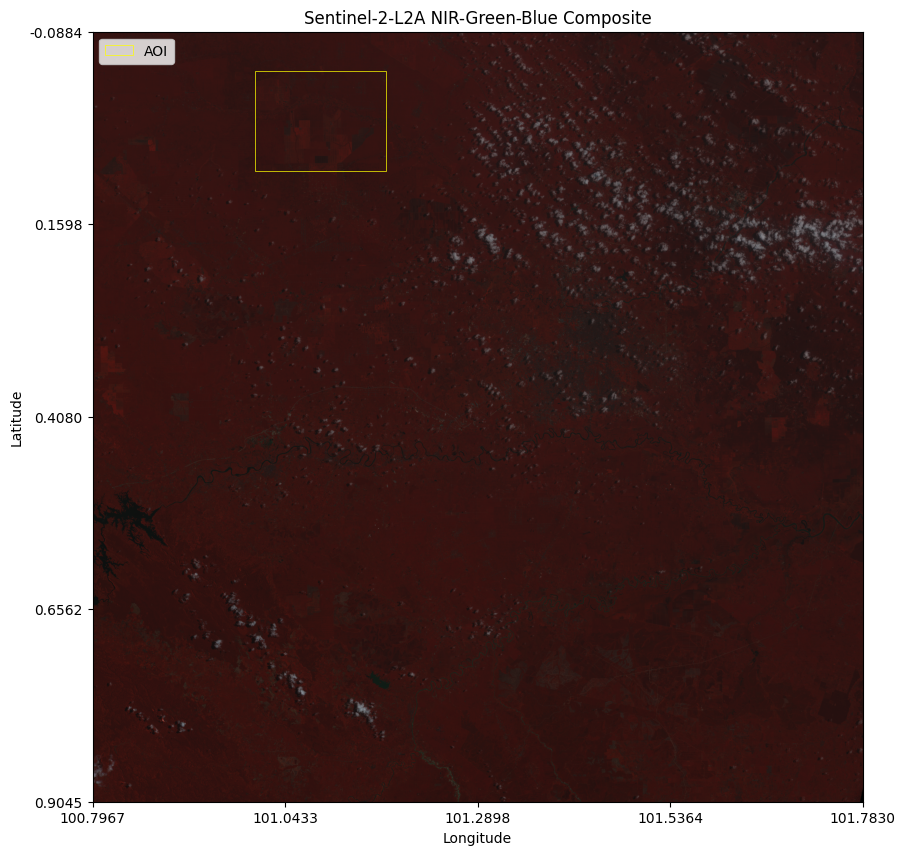

In [25]:
# Define the Sentinel-2 bands to use for the composite
band_names = [
    "B08",  # NIR band
    "B03",  # Green band
    "B02"   # Blue band
]

# Find the matching assets from the signed item
band_assets = {}
for band in band_names:
    asset = next(
        (asset for asset_key, asset in signed_item.assets.items()
         if asset.extra_fields.get("eo:bands", [{}])[0].get("name") == band),
        None,
    )
    if asset:
        band_assets[band] = asset.href

# Ensure we have all the bands
if len(band_assets) != len(band_names):
    missing_bands = set(band_names) - set(band_assets.keys())
    raise ValueError(f"Missing bands: {missing_bands}")

# Load the bands
# Assign NIR (B08), Green (B03), and Blue (B02) bands to the Red, Green, and Blue palettes respectively
with rasterio.open(band_assets["B08"]) as red_src, \
     rasterio.open(band_assets["B03"]) as green_src, \
     rasterio.open(band_assets["B02"]) as blue_src:

    # Read the data
    red = red_src.read(1)  # Red pallete
    green = green_src.read(1)  # Green pallete
    blue = blue_src.read(1)  # Blue pallete

    # Check for consistent shapes
    assert red.shape == green.shape == blue.shape, "Bands must have the same dimensions."

    # Stack bands into an array for visualization
    composite = np.dstack((red, green, blue))

    # Normalize the composite for display (0-255 range)
    composite_normalized = np.clip((composite / composite.max()) * 255, 0, 255).astype(np.uint8)

    # Get dataset bounds in EPSG:4326 for the grid
    full_bounds = red_src.bounds
    lon_min, lat_min, lon_max, lat_max = warp.transform_bounds(red_src.crs, "epsg:4326", *full_bounds)

    # Transform AOI bounds to the dataset's CRS
    aoi_bounds = features.bounds(aoi)  # AOI in EPSG:4326
    aoi_pixel_bounds = windows.from_bounds(
        *warp.transform_bounds("epsg:4326", red_src.crs, *aoi_bounds),
        transform=red_src.transform
    )

# Plot the RGB composite
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(composite_normalized)
ax.set_xlim(0, composite_normalized.shape[1])
ax.set_ylim(composite_normalized.shape[0], 0)  # Invert y-axis for image coordinates

# Set coordinate grid and labels
lon_ticks = np.linspace(lon_min, lon_max, 5)  # Number of longitude ticks
lat_ticks = np.linspace(lat_min, lat_max, 5)  # Number of latitude ticks

ax.xaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, composite_normalized.shape[1], len(lon_ticks))))
ax.xaxis.set_major_formatter(mticker.FixedFormatter([f"{lon:.4f}" for lon in lon_ticks]))

ax.yaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, composite_normalized.shape[0], len(lat_ticks))))
ax.yaxis.set_major_formatter(mticker.FixedFormatter([f"{lat:.4f}" for lat in lat_ticks]))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Add AOI overlay
rect = plt.Rectangle(
    (aoi_pixel_bounds.col_off, aoi_pixel_bounds.row_off),  # Top-left corner in pixels
    aoi_pixel_bounds.width,  # Width in pixels
    aoi_pixel_bounds.height,  # Height in pixels
    edgecolor="yellow",
    facecolor="none",
    linewidth=0.5,
    label="AOI"
)
ax.add_patch(rect)

# Add legend
ax.legend(loc="upper left")
plt.title("Sentinel-2-L2A NIR-Green-Blue Colour Composite")
plt.show()

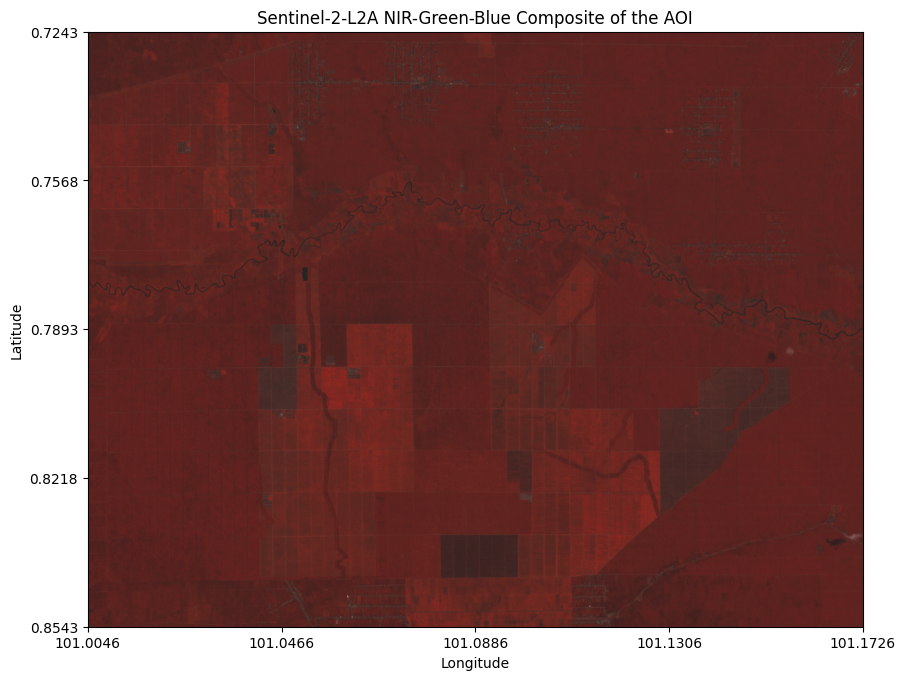

In [24]:
# Crop the image to the AOI bounds
with rasterio.open(band_assets["B08"]) as red_src, \
     rasterio.open(band_assets["B03"]) as green_src, \
     rasterio.open(band_assets["B02"]) as blue_src:

    # Read the data within the AOI
    aoi_window = windows.Window(
        col_off=int(aoi_pixel_bounds.col_off),
        row_off=int(aoi_pixel_bounds.row_off),
        width=int(aoi_pixel_bounds.width),
        height=int(aoi_pixel_bounds.height),
    )

    red_aoi = red_src.read(1, window=aoi_window)
    green_aoi = green_src.read(1, window=aoi_window)
    blue_aoi = blue_src.read(1, window=aoi_window)

    # Stack bands into an array for visualization
    composite_aoi = np.dstack((red_aoi, green_aoi, blue_aoi))

    # Normalize the composite for display (0-255 range)
    composite_aoi_normalized = np.clip((composite_aoi / composite_aoi.max()) * 255, 0, 255).astype(np.uint8)

    # Get dataset bounds in EPSG:4326 for the grid (for the cropped AOI)
    aoi_bounds = red_src.window_bounds(aoi_window)
    lon_min, lat_min, lon_max, lat_max = warp.transform_bounds(red_src.crs, "epsg:4326", *aoi_bounds)

# Plot the cropped AOI image with coordinate grid
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(composite_aoi_normalized)
ax.set_xlim(0, composite_aoi_normalized.shape[1])
ax.set_ylim(composite_aoi_normalized.shape[0], 0)  # Invert y-axis for image coordinates

# Set coordinate grid and labels
lon_ticks = np.linspace(lon_min, lon_max, 5)  # Number of longitude ticks
lat_ticks = np.linspace(lat_min, lat_max, 5)  # Number of latitude ticks

ax.xaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, composite_aoi_normalized.shape[1], len(lon_ticks))))
ax.xaxis.set_major_formatter(mticker.FixedFormatter([f"{lon:.4f}" for lon in lon_ticks]))

ax.yaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, composite_aoi_normalized.shape[0], len(lat_ticks))))
ax.yaxis.set_major_formatter(mticker.FixedFormatter([f"{lat:.4f}" for lat in lat_ticks]))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.title("Sentinel-2-L2A NIR-Green-Blue Colour Composite of the AOI")
plt.show()
